**Full-Name:**

**Stu-Code:**

# Download Data

##### Execute the cell below to download the data required for your homework (HW1's dataset).

In [ ]:
import gdown

url = 'https://drive.google.com/uc?id=1-2zT-_bKjN2o2QxwSviFwbCzcWE2PnkJ'

output = 'dataset.zip'
gdown.download(url, output, quiet=False)

In [ ]:
! unzip -q dataset.zip

# Initialization

In [1]:
import copy
import functools
import glob
import math
import os
import random
import zipfile
from functools import partial

import albumentations as A
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torchvision
from PIL import Image
from einops import rearrange, reduce
from einops.layers.torch import Rearrange
from matplotlib import pyplot as plt
from skimage import io
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, normalize
from torch import einsum, nn, optim
from torch.autograd import Variable
from torch.nn import Module, ModuleList, functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, Dataset
from torchvision import models, transforms, utils
from torchvision.datasets import MNIST
from torchvision.transforms import InterpolationMode
from torchvision.utils import make_grid
from tqdm import auto, tqdm

from data import load_mri_df  # Local import

In [2]:
import warnings
warnings.filterwarnings('ignore')

# Config

In [3]:
RANDOM_SEED = 42 # Must be used wherever can be used

torch.manual_seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

In [4]:
# Feel free to modify the following configurations
IMAGE_HEIGHT, IMAGE_WIDTH = 128, 128
BATCH_SIZE = 16
NUM_EPOCHS = 50

MODEL_PATH_TEMPLATE = 'best_diffusion_model_epoch_{}.pth'

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Torch Utils

In [6]:
# Functionality:
# 1. Device Allocation: If 'device' is specified (e.g., 'cpu', 'cuda'), all PyTorch tensor arguments are moved to this device.
# 2. Gradient Computation: If 'no_grad' is True, the function is executed in a torch.no_grad() context, which disables gradient calculations.
# Usage: Simply annotate your function with @device_grad_decorator(device=<desired_device>, no_grad=<True/False>)
def device_grad_decorator(device=None, no_grad=None):
    def decorator(func):
        @functools.wraps(func)
        def wrapper(*args, **kwargs):
            new_args = [arg.to(device) if isinstance(arg, torch.Tensor) else arg for arg in args] if device else args
            new_kwargs = {k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in kwargs.items()} if device else kwargs
            if no_grad == True:
                with torch.no_grad():
                    return func(*new_args, **new_kwargs)
            else:
                return func(*new_args, **new_kwargs)
        
        return wrapper
    return decorator

# Load and Process Data

This dataset contains brain MRI images and manual FLAIR abnormality segmentation masks, where each pixel value of masks indicates the presence or absence of cancer (0 and 1, respectively). The images correspond to 110 patients whose IDs are available in the patient_ids.csv file.


In [7]:
mri_df = load_mri_df('mri_scans/')
print(mri_df['has_cancer'].value_counts())
mri_df.head()

has_cancer
0    2556
1    1373
Name: count, dtype: int64


,patient_id,image_path,mask_path,has_cancer
0,TCGA_CS_6188_20010812,mri_scans/TCGA_CS_6188_20010812/TCGA_CS_6188_2...,mri_scans/TCGA_CS_6188_20010812/TCGA_CS_6188_2...,0
1,TCGA_CS_6188_20010812,mri_scans/TCGA_CS_6188_20010812/TCGA_CS_6188_2...,mri_scans/TCGA_CS_6188_20010812/TCGA_CS_6188_2...,0
2,TCGA_CS_6188_20010812,mri_scans/TCGA_CS_6188_20010812/TCGA_CS_6188_2...,mri_scans/TCGA_CS_6188_20010812/TCGA_CS_6188_2...,0
3,TCGA_CS_6188_20010812,mri_scans/TCGA_CS_6188_20010812/TCGA_CS_6188_2...,mri_scans/TCGA_CS_6188_20010812/TCGA_CS_6188_2...,0
4,TCGA_CS_6188_20010812,mri_scans/TCGA_CS_6188_20010812/TCGA_CS_6188_2...,mri_scans/TCGA_CS_6188_20010812/TCGA_CS_6188_2...,0


In [8]:
data = pd.read_csv('patient_ids.csv')
print(len(data.id.unique()), 'unique ids')
data.head()

110 unique ids


,id
0,TCGA_CS_4941
1,TCGA_CS_4942
2,TCGA_CS_4943
3,TCGA_CS_4944
4,TCGA_CS_5393


# Visualization

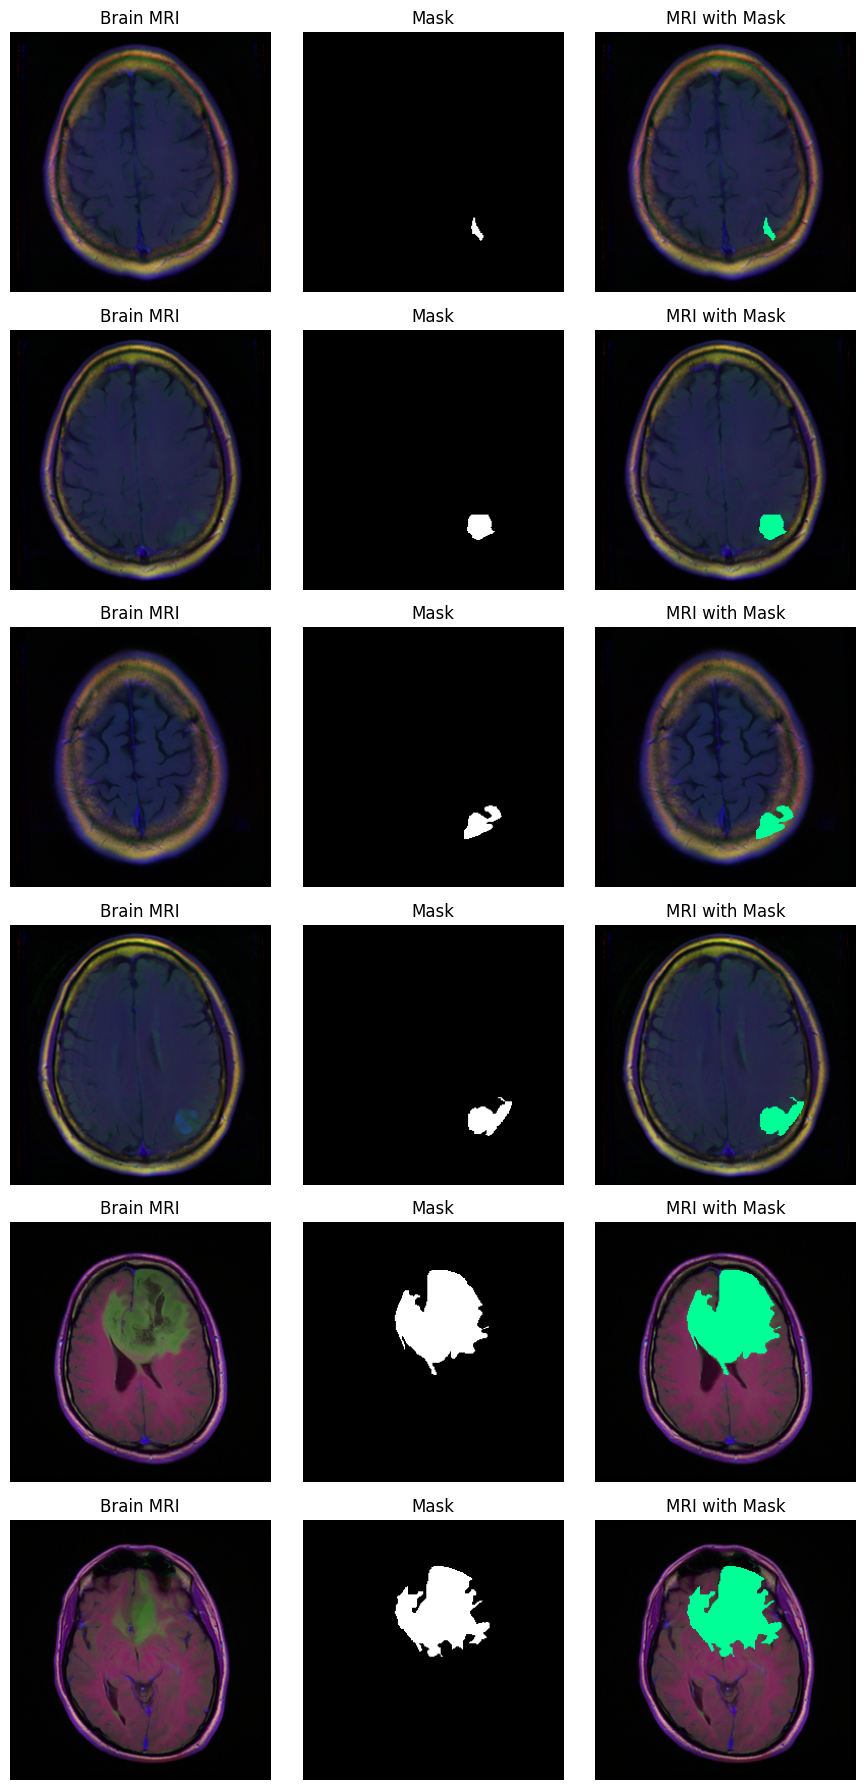

In [9]:
def visualize_img(ax, img, title, is_mask=False):
    ax.title.set_text(title)
    if is_mask == False:
        ax.imshow(img)
    else:
        ax.imshow(img, cmap='gray')
    ax.axis('off')

max_cnt, cnt, i = 6, 0, 0
fig, axs = plt.subplots(6,3, figsize=(9, 3 * max_cnt))
for i in mri_df.index:    
    has_cancer = mri_df.at[i, 'has_cancer']
    if (has_cancer==1):
        img = io.imread(mri_df.image_path[i])
        mask = io.imread(mri_df.mask_path[i])
        visualize_img(axs[cnt][0], img, 'Brain MRI')
        visualize_img(axs[cnt][1], mask, 'Mask', is_mask=True)
        img[mask==255] = (0,255,150)
        visualize_img(axs[cnt][2], img, 'MRI with Mask')
        cnt +=1
    
    if cnt==max_cnt:
        break

fig.tight_layout()
plt.show()

# Problem Statement

## Denoising Diffusion Probabilistic Models for Brain Tumor Segmentation in MRI Images

In this notebook, we are going to implement a DPM-based model for brain tumor segmentation over MRI images.
Below is an overview of the process you are going to implement step by step:

## Diffusion Models:

Diffusion models are generative models that consist of two main stages of **Forward** and **Reverse**.

### Forward Diffusion Process
Given a **segmentation label** sampled from the real distribution, we add small amount of Gaussian noise to the sample in $T$ steps, producing a sequence of noisy segmentation masks. The data sample $mask_0$ gradually loses its distinguishable features as the step $t$ becomes larger. Eventually when $T \to \infty$, $mask_T$ is equivalent to an isotropic Gaussian distribution.

<p style="text-align: center;">
  <img src="images/diff_forward.png" style="display: block; margin: auto;" width="900"/>
</p>

<p style="text-align: center;">
  <img src="images/diff_forward2.png" style="display: block; margin: auto;" width="600"/>
</p>

### Reverse Diffusion Process

In this phase, a UNet architecture is trained to accurately reverse the noise addition process and reconstruct the original data. It does this by estimating the specific amount of noise that was added in the previous step.

<p style="text-align: center;">
  <img src="images/diff_reverse.png" style="display: block; margin: auto;" width="900"/>
</p>

# Methodology:

Following the standard implementation of Diffusion Probabilistic Models (DPM), a U-Net architecture is employed for learning. To achieve segmentation, the step estimation function ($\epsilon_{\theta}$) is conditioned on the raw image prior, described by:

$$
\epsilon_{\theta}(x_t, I, t) = D((E_{t}^{I} + E_{t}^{x}, t))
$$

where $E_{t}^{I}$ is the conditional feature embedding (the raw image embedding), and $E_{t}^{x}$ is the segmentation map feature embedding at the current step. These components are combined and forwarded to a U-Net decoder $D$ for reconstruction. The step index $t$ is integrated with the embeddings and decoder features, leveraging a shared learned lookup table.


<p style="text-align: center;">
  <img src="images/model_overview.png" style="display: block; margin: auto;" width="800"/>
</p>

The loss of our model is represented by the following equation: 
$$
  \mathcal{L} = \mathbb{E}_{mask_0,\epsilon,t}[\lVert \epsilon - \epsilon_\theta(\sqrt{\bar{a}_t}mask_0 + \sqrt{1 - \bar{a}_t}\epsilon, I_i,t) \rVert^2]
$$


In each iteration, a random pair of raw image $I_i$ and segmentation label $mask_i$ are sampled for training. The iteration number is sampled from a uniform distribution and $\epsilon$ from a Gaussian distribution. The main architecture of the model is a modified ResUNet, which we implement with a ResNet encoder followed by a UNet decoder. $I$ and $x_t$ (noisy mask at the step=$t$) are encoded with two individual encoders.



# U-Net Architecture

Please find below a description of the components of the U-Net architecture that will be implemented for this task:

### 1) Dynamic Encoding Process

- *FF-Parser Input*: The segmentation map is first input into the Feature Frequency Parser (FF-Parser), which helps to reduce high-frequency noise and refine the feature representation.
- *Attentive Fusion*: After FF-Parser processing, the denoised feature map is combined synergistically with the prior image embeddings. An attentive-like mechanism is employed to enhance regional attention and feature saliency.
- *Iterative Refinement*: The enriched feature map is then subject to iterative refinement through the FF-Parser and the attentive mechanism, culminating at the bottleneck phase.
- *Bottleneck Convergence*: At this point, the processed feature map is added to the UNet encoder's outputs, resulting in an improved segmentation map that proceeds to the final encoding stage.

### 2) Time Encoding Block
- *Sinusoidal Embedding Calculation*: This step begins with the calculation of sinusoidal timestep embeddings.
- *Initial Processing Layers*: These embeddings are then passed through a linear layer, followed by SiLU activation, and another linear layer.
- *Integration into Residual Blocks*: Time features are then integrated into residual blocks. This is achieved either through straightforward spatial addition or via adaptive group normalization.

### 3) Bottleneck Block
- *Embedding Fusion*: At the core of the U-Net, this phase combines the embeddings from the UNet's encoder with those from the Dynamic Encoding, preparing them for the final encoding stage.

### 4) Encoder & Decoder Blocks 
+ *Initial Convolution*: The encoder begins with separate initial convolutional layers for the mask and input image, preparing the features for downstream processing. 
+ *Residual Blocks:* As a base sub-module, we define each ResNet block as two consecutive convolutional layers with a SiLU activation in between and Group Normalization after each convolutional layer. You can use this module in Down/Up blocks. Also, by removing the residual connection, you can use this block as a convolutional network throughout the network.
+ *Attention:* This is also a sub-module consisting of a Layer Normalization, Multi-head Attention, a residual connection, a feed-forward network, and another residual connection.
+ *Time Embedding Integration*: Each residual block in the downsampling and upsampling stages integrate time embeddings.



## 1) Dynamic Encoding Process


To achieve segmentation, we condition the step estimation function by using a  **Dynamic Conditional Encoding** process. At step $t$, we add the segmentation map feature embedding and the raw image embedding and send them to a UNet decoder $D$ for reconstruction. In most conditional DPM, the conditional prior is a unique given information. However, medical image segmentation is more challenging due to its ambiguous objects, where lesions or tissues are often difficult to differentiate from the background. Moreover, low-contrast image modalities such as MRI images make it even more challenging. Hence, given only a static image $I$ as the condition for each step is hard to learn.

We will implement a dynamic conditional encoding for each step to address this issue. On one hand, the raw image contains accurate segmentation target information but is hard to differentiate from the background. On the other hand, the current-step segmentation map contains enhanced target regions but is not accurate. Therefore, integrating the current-step segmentation information $x_t$ into the conditional raw image encoding for the mutual complement is a reasonable response. To be specific, we will integrate this on the feature level by fusing conditional feature maps and image encoding features through an **attentive-like mechanism**. This process helps the model to localize and calibrate the segmentation dynamically. In particular, two feature maps are first applied layer normalization and multiplied together to get an affinity map. Then we multiply the affinity map with the condition encoding features to enhance the attentive region, which is: $$
A(m_I^k, m_x^k) = (\text{LayerNorm}(m_I^k) \otimes \text{LayerNorm}(m_x^k)) \otimes m_I^k
$$



### Exercise 1 - Attention-like Mechanism (5 pts)

In [10]:
# Note: Please use the provided `LayerNorm` for consistency and performance.
from unet_util import LayerNorm

class AttentionLikeMechanism(nn.Module):
    def __init__(self, dim):
        super().__init__()
        """
        Args:
            dim (int): The number of features in the input tensors, typically the channel dimension.

        Attributes:
            layer_norm_i (LayerNorm): Layer normalization for the image feature tensor.
            layer_norm_x (LayerNorm): Layer normalization for the input segmentation mask tensor.
        """
        # TODO: Initialize layer normalization for the image and mask, enabling trainable biases for added flexibility.
        self.layer_norm_i = 
        self.layer_norm_x = 
        
    def forward(self, x, image):
        """
        Args:
            x (Tensor): The noisy segmentation mask at step t and layer l of the U-Net's encoder with shape [batch_size, channels, height, width].
            image (Tensor): The embedding of the image combined with feature maps from a previous fusion layer with shape [batch_size, channels, height, width].

        Returns:
            Tensor: The refined segmentation mask, having the same shape as the input tensors with shape [batch_size, channels, height, width].
        """
        # TODO: Normalize inputs for consistent feature scaling and improved model stability.
        normed_x = 
        normed_i = 

        # TODO: Combine normalized tensors using the specified mechanism to refine the segmentation mask.
        x = 
        return x

There is an issue with integrating the embedding of $x_t$ as it generates additional high-frequency noise. To overcome this problem, we need to restrict the high-frequency elements in the features. We can achieve this by training an attentive (weight) map with parameters, which will be applied to the features in **Fourier space**. The following is a step-by-step explanation of this process:


<p style="text-align: center;">
  <img src="images/ff_parser.png" style="display: block; margin: auto;" width="600"/>
</p>



<ul>
  <li><strong>1):</strong> Performing 2D FFT(fast fourier transform) along the spatial dimensions: $$
M = \mathcal{F}[m] \in \mathbb{C}^{H \times W \times C}
$$</li>
  <li><strong>2):</strong> We then modulate the spectrum of $m$ by multiplying a parameterized attentive map $A$ to $M$: $$ A \in \mathbb{C}^{H \times W \times C}, \  M' = A \otimes M \ (elementwise \ product)$$</li>
    <li><strong>3):</strong> We reverse $M'$ back to the spatial domain by adopting inverse FFT: $$ m' = \mathcal{F}^{-1}[M'] $$</li>
</ul>


This FF-Parser can be regarded as a learnable version of frequency filters which are wildly applied in the digital image processing. Different from the spatial attention, it globally adjusts the components of the specific frequencies. Thus it can be learn to constrain the high-frequency component for the adaptive integration.

### Exercise 2 - Fourier-space Features (10 pts)

In [11]:
from torch.fft import fft2, ifft2

class FFParser(nn.Module):
    def __init__(self, feature_map_size, dim):
        """
        Args:
            feature_map_size (int): The size of the spatial dimensions (height and width) of the feature maps.
            dim (int): The number of channels in the feature maps.

        Attributes:
            ff_parser_attn_map (Parameter): A learnable tensor that serves as the attentive map in the Fourier space. Initialized to ones.
        """
        super().__init__()
        # TODO: Initialize the learnable attentive map for frequency modulation.
        self.ff_parser_attn_map = 

    def forward(self, x):
        """
        Args:
            x (Tensor): The input feature map tensor with shape [batch_size, channels, height, width].

        Returns:
            Tensor: The processed feature map, having the same shape as the input, with high-frequency components modulated.
        """
        # Preserve the original data type for consistency after processing.
        dtype = x.dtype

        # TODO: Apply 2D FFT and modulate the spectrum with the learnable attentive map.
        x = 

        # TODO: Transform back to spatial domain using inverse FFT and retain only the real component.
        x = 
        
        x = x.type(dtype)
        return x

### Exercise 3 - Putting All Together (5 pts)

In [12]:
# Note: Please use the provided `ResnetBlock` for consistency and performance.
from unet_util import ResnetBlock

class DynamicFusionLayer(nn.Module):
    def __init__(self, feature_map_size, dim):
        """
        Args:
            feature_map_size (int): The size of the spatial dimensions (height and width) of the feature maps.
            dim (int): The number of channels in the feature maps.
        Attributes:
            ff_parser (FFParser): Module to modulate high-frequency components in the feature map.
            attention (AttentionLikeMechanism): Module to apply an attention-like mechanism for feature enhancement.
            block (ResnetBlock): A ResNet block for additional feature processing and refinement.
        """
        super().__init__()
        # TODO: Initialize components
        self.ff_parser = 
        self.attention = 
        self.block = 

    def forward(self, x, image):
        """
        Args:
            x (Tensor): The input segmentation map tensor with shape [batch_size, channels, height, width].
            image (Tensor): The prior image embedding tensor with shape [batch_size, channels, height, width].

        Returns:
            Tensor: The output of the Dynamic Fusion Layer, representing the enhanced and refined feature map.
        """
        # TODO: Reduce high-frequency noise using the FF-Parser.
        x = 
        
        # TODO: Apply attention mechanism.
        attention_out = 

        # TODO: Further refine the features using the ResNet block.
        x = 
        return x

## 2) Time Encoding Block

<p style="text-align: center;">
  <img src="images/time_pe.png" style="display: block; margin: auto;" width="600"/>
</p>

### Exercise 4 - Sinusoidal Positional Encoding for the Time Feature (5 pts)

In [13]:
class TimeSinusoidalPE(nn.Module):
    def __init__(self, dim, out_dim):
        """
        Args:
            dim (int): The dimension of the sinusoidal embedding's space.
            out_dim (int): The dimension of the output after projection.

        Attributes:
            projector (nn.Sequential): Projection layers to map the encoding to the output dimension.
            sin_cos_emb (Tensor): Precomputed sinusoidal embeddings.
        """
        super().__init__()
        
        # Precompute sinusoidal embeddings
        half_dim = dim // 2
        emb = torch.exp(torch.arange(half_dim, dtype=torch.float32) * -(math.log(10000) / (half_dim - 1)))
        emb = torch.cat((emb.sin(), emb.cos())).view(1, -1)
        # TODO: Register a buffer for the sinusoidal positional encoding
         

        # TODO: Define the projection layers. Linear -> SiLU -> Linear
        self.projector = nn.Sequential(
            
        )

    def forward(self, x):
        """
        Args:
            x (Tensor): Input tensor representing time or a one-dimensional sequence, shape [batch_size].

        Returns:
            Tensor: Projected sinusoidal encoding, shape [batch_size, out_dim].
        """
        # TODO: Multiply the input to the precomputed sinusoidal embeddings.
        x = 
        x = self.projector(x)
        return x

## 3) Bottleneck Block

### Exercise 5 - Bottleneck Layer (15 pts)

In [14]:
# Note: Please use the provided `ResnetBlock` and `Transformer` for consistency and performance.
from unet_util import ResnetBlock, Transformer

class BottleNeck(nn.Module):
    def __init__(self, dim, time_embedding_dim, transformer_layers, groups=8, **attention_configs):
        """
        Args:
            dim (int): The number of channels in the feature maps.
            time_embedding_dim (int): The dimension of the time embedding.
            groups (int, optional): The number of groups for grouped convolutions in ResnetBlocks. Defaults to 8.
            **transformer_configs: Additional configurations for the Transformer layer.

        Attributes:
            conv_mask (ResnetBlock): ResNet block for processing the mask.
            conv_img (ResnetBlock): ResNet block for processing the image.
            transformer_fuser (Transformer): Transformer layer for feature fusion.
            conv_fuser (ResnetBlock): ResNet block for processing the fused features.
        """
        super().__init__()

        # TODO: Initialize convolutional Resnet blocks for mask and image processing.
        self.conv_mask = 
        self.conv_img = 

        # TODO: Transformer layer for feature fusion.
        self.transformer_fuser = 

        # TODO: Convolutional Resnet block for post-fusion processing.
        self.conv_fuser = 

    def forward(self, x, image, time_embedding):
        """
        Args:
            x (Tensor): The input mask tensor with shape [batch_size, channels, height, width].
            image (Tensor): The input image tensor with shape [batch_size, channels, height, width].
            time_embedding (Tensor): The time embedding tensor with shape [batch_size, time_embedding_dim].

        Returns:
            Tensor: The output tensor representing fused and refined features, with shape [batch_size, channels, height, width].
        """
        # TODO: Apply first conv blocks to mask and image separately.
        x = 
        image = 

        # Add mask and image features.
        x = x + image

        # TODO: Apply transformer.
        x = 

        # TODO: Refine the fused features.
        x = 
        return x

# U-Net Model

### Data Flow Details

1. **Preprocess Input:**
   - Apply the initial convolution layers to mask and image.

1. **Encoding Path:**
   - Initialize an empty list `skip_connections` for storing features for skip connections.
   - Iterate through the encoder layers (`mask_encoders`, `image_encoders`, and `dynamic_fusion_layers`):
     - For each layer:
       - Apply the first ResNet block to `x` (mask) and `image_emb` (image embedding), incorporating the time embedding `t`.
       - Append `[x, image_emb]` to `h` for skip connections (if `skip_connect_image_feature_maps` is enabled, otherwise append `[x]`).
       - Apply the second ResNet block to both `x` and `image_emb`.
       - Apply the attention mechanism to both `x` and `image_emb`.
       - Fuse `x` and `image_emb` using `dynamic_fusion_layer`.
       - Append `[x, image_emb]` to `h` for skip connections (if `skip_connect_image_feature_maps` is enabled, otherwise append `[x]`).
       - Downsample (except the last layer that you must use `nn.Conv2d`) `x` and `image_emb` using the last layer in `mask_encoder` and `image_encoder` respectively.


3. **Bottleneck:**
   - Pass `x`, `image_emb`, and `t` through the `bottleneck` layer for processing.

4. **Decoding Path:**
   - Iterate through the decoder layers in reverse order:
     - For each layer:
       - Concatenate `x` with the corresponding features from `h` (popped from the end).
       - Apply the first ResNet blocks.
       - Concatenate the result with the corresponding features from `h` (popped from the end).
       - Apply the second Resnet block, following by an attention mechanism.
       - Upsample or `nn.Conv2d` `x` using the last layer in the decoder (similar to the encoder).


5. **Final Output:**
   - Concatenate the final `x` with the output of the first conv layer.
   - Pass through the `final_res_block` and `final_conv` to produce the output segmentation mask.

The implementation of the `forward` function should closely follow the above steps, ensuring proper data flow and feature processing through the U-Net architecture.

### Exercise 6 - UNet Implementation (60 pts - 30 pts each function)

In [15]:
# Note: Please use the provided modules for consistency and performance.
from unet_util import Attention, LinearAttention, Downsample, Upsample, Residual, ResnetBlock, InitWeights_He

class Unet(nn.Module):
    def __init__(
        self,
        image_size,
        num_layers,
        weight_initializer=InitWeights_He,
        linear_attn_layers=None,
        skip_connect_image_feature_maps=False,
        first_conv_channels=16,
        time_embedding_dim=128,
        mask_channels=1,
        output_channels=1,
        image_channels=3,
        **kwargs,
    ):
        """
        Args:
            image_size (int): Size of the input image.
            num_layers (int): Number of encoder/decoder blocks.            
            weight_initializer (Class): A class to initialize the weights of the layers.
            linear_attn_layers (list of bool): Specifies layers using linear attention in each encoder/decoder block. True for layer indices with linear attention.
            skip_connect_image_feature_maps (bool): If True, concatenate connections for image feature maps.
            config (dict): Configuration dictionary with model parameters.
        """
        super().__init__()

        # Basic model configuration and parameters
        self.num_layers = num_layers
        self.image_size = image_size
        self.skip_connect_image_feature_maps = skip_connect_image_feature_maps
        self.weight_initializer = weight_initializer
        self.first_conv_channels = first_conv_channels
        self.image_channels = image_channels
        self.mask_channels = mask_channels
        self.output_channels = output_channels
        self.time_embedding_dim = time_embedding_dim
        self.linear_attn_layers = linear_attn_layers or [i < (self.num_layers - 1) for i in range(self.num_layers)] # [T, T, T, F]

        # TODO: Initialize the initial convolution layers for mask and image inputs (nn.Conv2d k=7, p=3)
        self.mask_initial_conv = 
        self.img_initial_conv = 
        
        
        # TODO: Initialize time embedding layer
        self.time_embedding_layer = 

        attention_heads = kwargs.get('att_heads', 4)
        attention_head_dim = kwargs.get('att_head_dim', 32)
        bottleneck_transformer_num_layers = kwargs.get('bottleneck_transformer_layers', 1)

        # Calculate hidden channel sizes for each resolution level
        channels_num_factors = [int(2 ** i) for i in range(len(self.linear_attn_layers))]
        hidden_channels =  [self.first_conv_channels, *map(lambda m: self.first_conv_channels * m, channels_num_factors)]
        in_out = list(zip(hidden_channels[:-1], hidden_channels[1:]))
        
        num_resolutions = len(in_out)
        
        self.dynamic_fusion_layers = ModuleList([])
        self.mask_encoders = ModuleList([])
        self.image_encoders = ModuleList([])


        # This loop constructs each encoder layer with two ResnetBlocks, a Residual Attention module (full or linear), 
        # and concludes with a Downsample layer, except for the last layer which uses a Conv2D layer.
        current_feature_map_size = self.image_size
        for i, ((dim_in, dim_out), use_linear) in enumerate(zip(in_out, self.linear_attn_layers)):
            # TODO: 
            is_last_layer =  

            # TODO: initialize the resnet blocks.
            first_resnet_block = 
            second_resnet_block = 
            
            # TODO: Choose between LinearAttention and Attention and specify head dimensions (your choice).
            attention_class = # LinearAttention or Attention
            attention_configs = dict(
                dim_head=attention_head_dim,
                heads=attention_heads,
            )
            attention = attention_class(dim_in, **attention_configs)

            # TODO: Initialize the dynamic encoding layer and the last conv layer as discussed earlier.
            dynamic_fusion_layer = 
            last_conv_layer = # Downsample or nn.Conv2d
            
            # TODO: Adjust feature map size for next layer. 
            current_feature_map_size = 
            
            self.dynamic_fusion_layers.append(dynamic_fusion_layer)
            self.mask_encoders.append(ModuleList([
                first_resnet_block,
                second_resnet_block,
                Residual(attention),
                last_conv_layer,
            ]))            
            

        self.image_encoders = copy.deepcopy(self.mask_encoders)
        
        # Initialize the bottleneck layer
        self.bottleneck = BottleNeck(
            hidden_channels[-1],
            self.time_embedding_dim,
            transformer_layers=bottleneck_transformer_num_layers,
            **dict(
                dim_head=attention_head_dim,
                heads=attention_heads,
            ),
        )
        
        # This pipeline follows a similar process as the one used for initializing the encoders, but it's done in reverse.
        self.decoders = ModuleList([])
        for i, ((dim_in, dim_out), use_linear) in enumerate(zip(reversed(in_out), reversed(self.linear_attn_layers))):
            # TODO: 
            is_last_layer = 
            
            # Please specify the dim of the skip connection while taking into account the self.skip_connect_image_feature_maps attribute.
            skip_connect_dim = dim_in * (2 if self.skip_connect_image_feature_maps else 1)


            # TODO: initialize the resnet blocks.
            first_resnet_block =
            second_resnet_block = 
            
            # TODO:Choose between LinearAttention and Attention and specify head dimensions (your choice).
            attention_class = 
            attention_configs = dict(
                dim_head=attention_head_dim,
                heads=attention_heads,
            )
            attention = attention_class(dim_out, **attention_configs)

            # TODO: Initialize the last conv layer as discussed earlier.
            last_conv_layer = 
            
            self.decoders.append(ModuleList([
                first_resnet_block,
                second_resnet_block,
                Residual(attention),
                last_conv_layer,
            ]))
            

        # A ResnetBlock mapping the number of channels to self.first_conv_channels
        self.final_res_block = ResnetBlock(self.first_conv_channels * 2, self.first_conv_channels, time_embedding_dim=self.time_embedding_dim)
        
        # TODO Genererating the final output 
        self.final_conv = 
        
        # TODO: Apply the weight initializer if provided       
        if self.weight_initializer is not None:
            None

    @device_grad_decorator(device=device)   
    def forward(self, x, time, image):
        """
        Args:
            x (torch.Tensor): The input mask tensor.
            time (torch.Tensor): The tensor representing time embeddings.
            image (torch.Tensor): The input image tensor.
    
        Returns:
            torch.Tensor: The output tensor after segmentation.
        """
        dtype, skip_connect_image = x.dtype, self.skip_connect_image_feature_maps       

        # Initial convolution layers for mask and image
        x = self.mask_initial_conv(x)
        image_emb = self.img_initial_conv(image)

        x_clone = x.clone()

        # Generate time embeddings
        t = self.time_embedding_layer(time)
        skip_connections = []

        # Encoding path: iterate through each layer in mask and image encoders
        for mask_encoder, image_encoder, dynamic_fusion_layer in zip(self.mask_encoders, self.image_encoders, self.dynamic_fusion_layers):
            block_1, block_2, attention, downsample = mask_encoder
            image_block_1, image_block_2, image_attention, image_downsample = image_encoder
            
            # TODO: Apply the first ResBlock to mask and image.
            x = 
            image_emb = 

            
            # TODO: Store the features in h for later use in skip connections
            skip_connections.append(None)

            # TODO: Apply the second ResBlock and attention to the mask and image.
            x = 
            image_emb = 
            
            x = 
            image_emb = 
            
            # TODO: Dynamic fusion of mask and image features
            image_emb = 
            
            # TODO: Storing the features in h for later use in skip connections
            skip_connections.append(None)

            # TODO: Perform either downsampling or convolution to the mask and image.
            x = 
            image_emb = 
                    
        # Processing through the bottleneck
        x = 

        # Decoding path: processing through decoders
        for block_1, block_2, attention, upsample in self.decoders:
            
            # TODO: Concatenate mask with the corresponding skip connection features
            x = 
            
            # TODO: Apply the first ResBlock
            x = 
            
            # TODO: Concatenate mask with the corresponding skip connection features
            x = 
            
            # TODO: Apply the remaining blocks
            x = 
            x = 
            x = 

        # Apply the final convolutions
        x = torch.cat((x, x_clone), dim = 1)
        x = self.final_res_block(x, t)
        return self.final_conv(x)

# Denoising Probabilistic Diffusion

## Noise Scheduling

### Exercise 7 - Implement Linear, Cosine, & Quadratic Variance Scheduling (15 pts - 5 pts each)

In [ ]:
class NoiseScheduler:
    def __init__(self, timesteps, beta_min=0.0001, beta_max=0.02, mode='linear', cosine_s=8e-3):
        """
        Args:
            timesteps (int): The number of timesteps for the noise schedule.
            beta_min (float): The minimum value of beta in the schedule.
            beta_max (float): The maximum value of beta in the schedule.
            mode (str): The type of scheduling to use. Options are 'quad', 'linear', 'cosine'.
            cosine_s (float): S parameter for cosine scheduling. Defaults to 8e-3.
        """
        self.timesteps = timesteps
        self.beta_min = beta_min
        self.beta_max = beta_max
        self.mode = mode
        self.cosine_s = cosine_s
        assert mode in ['quad', 'linear', 'cosine'], '"Unsupported scheduling mode'
        
    def get_beta_schedule(self):
        # TODO: Quadratic scheduling
        if self.mode == "quad":
            betas = 
            
        # TODO: Linear scheduling
        elif self.mode == "linear":
            betas = 
            
        # TODO: Cosine scheduling
        elif self.mode == "cosine":
            betas =

        return betas # Numpy 

    def get_alpha_schedule(self):
        beta_schedule = self.get_beta_schedule()
        alpha_schedule = 1 - beta_schedule
        return alpha_schedule

    def get_alpha_bar_schedule(self):
        alpha_schedule = self.get_alpha_schedule()
        
        # TODO: 
        alpha_bar_schedule = 
        return alpha_bar_schedule

    def get_alphas_bar_previous_schedule(self):
        alpha_bar_schedule = self.get_alpha_bar_schedule()
        
        # TODO
        alpha_bars_prev = return alpha_bars_prev

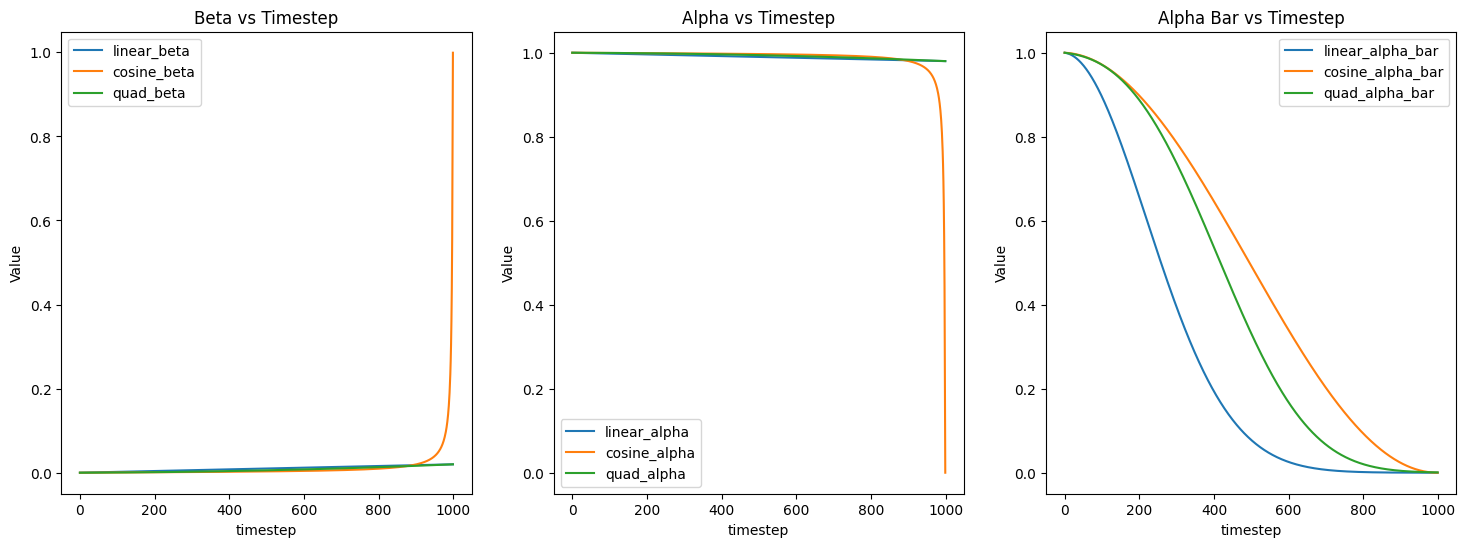

In [17]:
def create_noise_scheduler_dataframe(timesteps, beta_min, beta_max, modes):
    """
    Args:
        timesteps (int): Number of timesteps for the schedule.
        beta_min (float): Minimum beta value.
        beta_max (float): Maximum beta value.
        modes (list): List of scheduling modes to generate schedules for.

    Returns:
        pd.DataFrame: DataFrame containing beta, alpha, and alpha_bar schedules.
    """
    df = pd.DataFrame()
    df['timestep'] = np.arange(timesteps)

    for mode in modes:
        scheduler = NoiseScheduler(timesteps, beta_min, beta_max, mode)
        df[f'{mode}_beta'] = scheduler.get_beta_schedule()
        df[f'{mode}_alpha'] = scheduler.get_alpha_schedule()
        df[f'{mode}_alpha_bar'] = scheduler.get_alpha_bar_schedule()

    return df

def plot_scheduler_data(df, x_col, y_cols, titles):
    """
   Args:
        df (pd.DataFrame): DataFrame containing the scheduler data.
        x_col (str): Column name for the x-axis.
        y_cols (list of list): Lists of column names for the y-axis for each subplot.
        titles (list): Titles for each subplot.
    """
    plt.figure(figsize=(18, 6))
    
    for i, (y_col, title) in enumerate(zip(y_cols, titles), 1):
        plt.subplot(1, len(y_cols), i)
        for col in y_col:
            plt.plot(df[x_col], df[col], label=col)
        plt.xlabel(x_col)
        plt.ylabel('Value')
        plt.title(title)
        plt.legend()


modes = ['linear', 'cosine', 'quad']
noise_df = create_noise_scheduler_dataframe(timesteps=1000, beta_min=0.0001, beta_max=0.02, modes=modes)

y_cols = [
    [f'{mode}_beta' for mode in modes],
    [f'{mode}_alpha' for mode in modes],
    [f'{mode}_alpha_bar' for mode in modes]
]
titles = ['Beta vs Timestep', 'Alpha vs Timestep', 'Alpha Bar vs Timestep']

plot_scheduler_data(noise_df, 'timestep', y_cols, titles)
plt.show()

## Diffusion Model

### Exercise 8 - Diffusion Implementation (100 pts)


- ```def forward(self, mask, conditioned_image, *args, **kwargs) - 20 pts```

<p style="text-align: center;">
  <img src="images/train_algo.png" style="display: block; margin: auto;" width="400"/>
</p>

- ```def sample(self, conditioned_image) - 20 pts```

<p style="text-align: center;">
  <img src="images/sample_algo.png" style="display: block; margin: auto;" width="400"/>
</p>

- ```def calculate_xt_from_x0(self, x_0, t, noise) - 10 pts```

$$
\begin{aligned}
\mathbf{x}_t &= \sqrt{\bar{\alpha}_t}\mathbf{x}_0 + \sqrt{1 - \bar{\alpha}_t}\boldsymbol{\epsilon} \\
\end{aligned}
$$

- ```def calculate_x0_from_xt(self, x_t, t, noise) - 10 pts```
$$
\mathbf{x}_0 = \frac{1}{\sqrt{\bar{\alpha}_t}}(\mathbf{x}_t - \sqrt{1 - \bar{\alpha}_t}\epsilon_t)
$$

- ```def estimate_mean(self, predicted_noise, x_t, t) - 10 pts```
$$
\begin{aligned}
\mu_\theta(\mathbf{x}_t, t) &= \frac{1}{\sqrt{\alpha_t}} \Big( \mathbf{x}_t - \frac{1 - \alpha_t}{\sqrt{1 - \bar{\alpha}_t}} \epsilon_\theta(\mathbf{x}_t, \; t) \Big)
\end{aligned}
$$
- ```def estimate_variance(self, t) - 10 pts```: 
$$
\begin{align}
    \Sigma_\theta(\mathbf{x}_t, t) = \sigma^2_t \cdot \mathbf{I} = 
\begin{cases}
  \tilde{\beta}_t = \frac{1 - \bar{\alpha}_{t-1}}{1 - \bar{\alpha}_t} \cdot \beta_t \;\; or \;\; \beta_t & \\[2.5ex]
  \exp(\mathbf{v} \log \beta_t + (1-\mathbf{v}) \log \tilde{\beta}_t) & 
\end{cases}
\end{align}
$$
<center><a href="https://arxiv.org/abs/2006.11239">Ho et al. (2020)</a> & <a href="https://arxiv.org/abs/2102.09672">Nichol & Dhariwal (2021)</a></center>

- ```def reverse_one_step(self, mask, t, conditioned_image) - 15 pts``` 

$$
\begin{aligned}
Calculates \;\; p_\theta(\mathbf{x}_{t-1} \vert \mathbf{x}_t)
\end{aligned}
$$
$$
\begin{aligned}
\mathbf{x}_{t-1} &= \mathcal{N}(\mathbf{x}_{t-1}; \frac{1}{\sqrt{\alpha_t}} \Big( \mathbf{x}_t - \frac{1 - \alpha_t}{\sqrt{1 - \bar{\alpha}_t}} \epsilon_\theta(\mathbf{x}_t, t) \Big), \Sigma_\theta(\mathbf{x}_t, t))
\end{aligned}
$$

- ```def _setup_diffusion_tensors(self, betas, alphas, alpha_bars, alpha_bars_prev) - 5 pts```

In [19]:
# Note: Please use the provided modules for consistency and performance.
from unet_util import normalize_to_neg_one_to_one, unnormalize_to_zero_to_one, default, identity, ModelPrediction

class Diffusion(nn.Module):
    """
    A denoising probabilistic Gaussian diffusion model (DDPM).

    Attributes:
        model (nn.Module): Neural network model for generating predictions.
        image_channels (int): Number of input image channels.
        mask_channels (int): Number of mask channels.
        image_size (int): Size of the image.
        device (torch.device): Device to run the model (CPU or GPU).
        num_timesteps (int): Number of timesteps for the diffusion process.
        Various other attributes for the diffusion process.
    """

    def __init__(self, model, device=device, timesteps=1000, noise_schedule='cosine'):
        """
        Initialize the Diffusion model.

        Args:
            model (nn.Module): Neural network model for generating predictions.
            device (torch.device): Device to run the model (CPU or GPU).
            timesteps (int): Number of timesteps for the diffusion process.
            noise_schedule (str): Type of noise scheduling ('linear', 'cosine', etc.).
        """
        super().__init__()
        self.model = model
        self.image_channels = model.image_channels
        self.mask_channels = model.mask_channels
        self.image_size = model.image_size
        self.device = device        
        self._setup_diffusion_parameters(timesteps, noise_schedule)

    def _setup_diffusion_parameters(self, timesteps, noise_schedule):
        """
        Setup the diffusion process parameters.

        Args:
            timesteps (int): Number of timesteps for the diffusion process.
            noise_schedule (str): Type of noise scheduling.
        """
        noise_scheduler = NoiseScheduler(timesteps, mode=noise_schedule)
        betas = torch.tensor(noise_scheduler.get_beta_schedule())
        alphas = torch.tensor(noise_scheduler.get_alpha_schedule())
        alpha_bars = torch.tensor(noise_scheduler.get_alpha_bar_schedule())
        alpha_bars_prev = torch.tensor(noise_scheduler.get_alphas_bar_previous_schedule())

        self.num_timesteps = betas.shape[0]
        self._setup_diffusion_tensors(betas, alphas, alpha_bars, alpha_bars_prev)

    def _setup_diffusion_tensors(self, betas, alphas, alpha_bars, alpha_bars_prev):
        """
        Setup and convert diffusion tensors to the correct type and device, and register them as buffers.
    
        Args:
            betas, alphas, alpha_bars, alpha_bars_prev: Tensors for diffusion.
        """
        # TODO: register a buffer for the following parameters for later use ( pts):
        #       beta(t), log(beta(t)), alpha_bar(t), alpha_bar(t-1), sqrt(alpha_bar(t)), sqrt(1 - alpha_bar(t)),
        #       1 / sqrt(alpha(t)), 1 / sqrt(alpha_bar(t)), beta(t) / sqrt(1 - alpha_bar(t)), beta_tilda(t), log(beta_tilda(t)).
        
        beta_tilda = 
        
        self.register_buffer('betas', None)
        self.register_buffer('alpha_bars', None)
        self.register_buffer('alpha_bars_prev', None)
        self.register_buffer('sqrt_alpha_bars', None)
        self.register_buffer('sqrt_one_minus_alpha_bars', None)
        self.register_buffer('sqrt_inverse_alpha_bars', None)
        self.register_buffer('sqrt_inverse_alphas', None)
        self.register_buffer('estimated_mean_noise_coefficient', None)
        self.register_buffer('estimated_log_variance_beta_tilda', None)
        self.register_buffer('estimated_log_variance_beta', None)
        
        
    @device_grad_decorator(device=device, no_grad=True)
    def batch_select_time_indices(self, tensor, indices):
        """
        Args:
            tensor (torch.Tensor): The input tensor from which elements are to be extracted.
            indices (torch.Tensor): The tensor containing indices at which to extract elements.
        Returns:
            torch.Tensor: The reshaped tensor after extraction with shape [batch_size, 1, 1, 1]
        """
        return tensor.gather(dim=-1, index=indices).reshape(indices.shape[0], 1, 1, 1)

    @device_grad_decorator(device=device, no_grad=True)       
    def calculate_x0_from_xt(self, x_t, t, noise):
        """
        Predict the start image from noise.

        Args:
            x_t (tensor): The noisy image at timestep t.
            t (int): The current timestep.
            noise (tensor): The noise tensor.

        Returns:
            The predicted start image at t=0.
        """
        return 
    
    @device_grad_decorator(device=device, no_grad=True)
    def estimate_mean(self, predicted_noise, x_t, t):
        return 
        
        
    @device_grad_decorator(device=device, no_grad=True)    
    def estimate_variance(self, t):
        # Your are free between the options
        return 

    @device_grad_decorator(device=device, no_grad=True)
    def reverse_one_step(self, noisy_mask, t, conditioned_image):
        """
        Sample from the model.
        Args:
            mask (tensor): The input tensor.
            t (int): The current timestep.
            conditioned_image (tensor): Conditioning tensor.
        Returns:
            The predicted mask and the start mask.
        """
        return predicted_previous_mask
    
    @device_grad_decorator(device=device, no_grad=True)
    def sample(self, conditioned_image):
        """
        Generate a sample based on conditioning image.
    
        Args:
            conditioned_image (tensor): Conditioning images tensor with the shape of [batch_size, channels, height, width].    
        Returns:
            Generated masks tensor.
        """
        
        return generated_mask

    @device_grad_decorator(device=device)
    def calculate_xt_from_x0(self, x_0, t, noise):
        """
        Args:
            x_0 (tensor): The start image.
            t (int): The current timestep.
            noise (tensor): Optional noise tensor.

        Returns:
            Sampled image tensor.
        """
        
        return 

    @device_grad_decorator(device=device)
    def forward(self, mask, conditioned_image, *args, **kwargs):
        """
        Forward pass through the Diffusion model.

        Args:
            img (tensor): Input image tensor.
            conditioned_image (tensor): Conditioning image tensor.
            args: Additional arguments.
            kwargs: Keyword arguments.

        Returns:
            The loss for the model.
        """
        
        return loss

# Creata Dataset & DataLoader

#### Splitting To Train/Test/Val

Feel free to modify the code of this section.

In [24]:
def split_dataset(mri_df, x_col, y_col, stratify_col, test_size=0.1, random_state=RANDOM_SEED):
    X_train, X_test, y_train, y_test = train_test_split(
        mri_df[[x_col]],
        mri_df[[y_col, 'has_cancer']],
        test_size=test_size,
        random_state=random_state,
        stratify = mri_df[stratify_col],
    )
    
    train_df = pd.concat([X_train, y_train], axis=1).reset_index(drop=True)
    test_df = pd.concat([X_test, y_test], axis=1).reset_index(drop=True)
    return train_df, test_df

In [25]:
train_df, test_df = split_dataset(mri_df, 'image_path', 'mask_path', 'has_cancer')

print(f'train df count: {len(train_df)}')
print(f'test df count: {len(test_df)}')

train df count: 3536
test df count: 393


In [26]:
class BrainMRIDataset(Dataset):
    def __init__(self, dataframe, image_transform, mask_transform, joint_transform):
        self.dataframe = dataframe
        self.image_transform = image_transform
        self.mask_transform = mask_transform
        self.joint_transform = joint_transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        image = self.get_unprocessed_image(idx)
        mask = self.get_unprocessed_mask(idx)
        label = int(self.dataframe['has_cancer'][idx])
        transformed = self.joint_transform(image=image, mask=mask)
        
        image = transformed['image']
        mask = transformed['mask']

        image = self.image_transform(image)
        mask = self.mask_transform(mask)

        return image, mask, torch.tensor(label).int()

    def get_unprocessed_mask(self, idx):
        mask_path = self.dataframe['mask_path'][idx]
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        return mask
        
    def get_unprocessed_image(self, idx):
        image_path = self.dataframe['image_path'][idx]
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        return image

image_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((IMAGE_HEIGHT, IMAGE_WIDTH), interpolation=transforms.InterpolationMode.NEAREST),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
])
        
mask_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((IMAGE_HEIGHT, IMAGE_WIDTH), interpolation=transforms.InterpolationMode.NEAREST),
])

# TODO: Perform vertical and horizontal jointly to the image and mask.
joint_transform = A.Compose(
    None
)
mock_joint_transform = A.Compose([], p=1)

train_dataset = BrainMRIDataset(train_df, image_transform, mask_transform, joint_transform)
test_dataset = BrainMRIDataset(test_df, image_transform, mask_transform, joint_transform)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

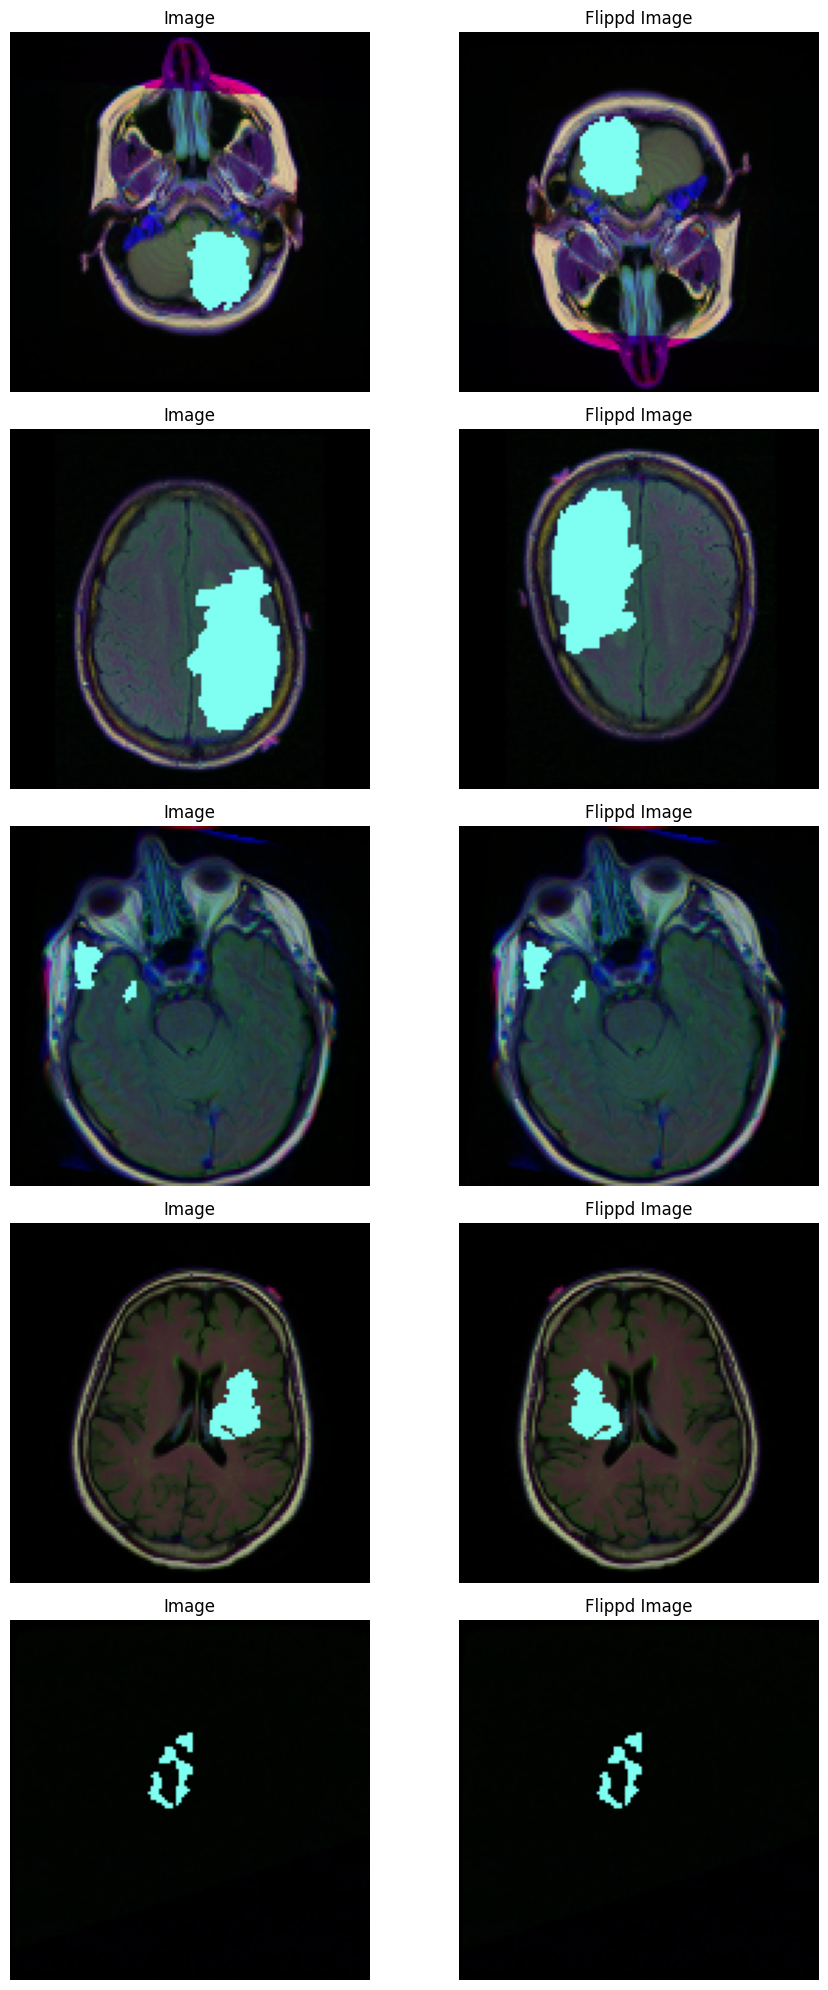

In [27]:
def test_joint_transform(
    dataset_class=BrainMRIDataset,
    df=train_df,
    joint_transform=joint_transform,
    mock_joint_transform=mock_joint_transform,
    image_transform=image_transform,
    mask_transform=mask_transform,
    num_samples=5
):
    partial_class = partial(dataset_class, dataframe=df ,image_transform=image_transform, mask_transform=mask_transform)
    org_dataset = partial_class(joint_transform=mock_joint_transform)
    flipped_dataset = partial_class(joint_transform=joint_transform)
    random_indices = df[df['has_cancer'] == 1][['has_cancer']].sample(num_samples).reset_index()['index'].tolist()
    plt.figure(figsize=(10, 4 * num_samples))
    
    for i, index in enumerate(random_indices):
        org_image, org_mask, _ = org_dataset[index]
        org_image, org_mask = org_image.permute(1, 2, 0).numpy(), org_mask.permute(1, 2, 0).squeeze(2).numpy()
    
        flipped_image, flipped_mask, _ = flipped_dataset[index]
        flipped_image, flipped_mask = flipped_image.permute(1, 2, 0).numpy(), flipped_mask.permute(1, 2, 0).squeeze(2).numpy()
        org_image[org_mask==1] = (0, 1, .9)
        flipped_image[flipped_mask==1] = (0, 1, .9)
        org_image = unnormalize_to_zero_to_one(org_image)
        flipped_image = unnormalize_to_zero_to_one(flipped_image)
        plt.subplot(num_samples, 2, 2 * i + 1)
        plt.imshow(org_image)
        plt.title(f"Image")
        plt.axis("off")
    
        plt.subplot(num_samples, 2, 2 * i + 2)
        plt.imshow(flipped_image)
        plt.title(f"Flippd Image")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

test_joint_transform()

# Training

In [34]:
# TODO: Define your architecture
unet = Unet(
    image_size=None
    num_layers=None,
    # And other attributes ...
).to(device)

diffusion = Diffusion(
    unet,
    device=device,
    timesteps=None,
    noise_schedule=None,
    # And other attributes ...
).to(device)

print('Number of parameters: ', sum(p.numel() for p in unet.parameters()))

Number of parameters:  3936529


In [35]:
# TODO: Specify your lr, optimizer, and learning rate scheduler
optimizer = 
scheduler = 

In [36]:
def plot_prediction(axs, index, dataset, prediction):
    img = dataset.get_unprocessed_image(index)
    _, _, label = dataset[index]
    
    label = int(label)
    status = 'Cancerous' if label == 1 else 'Non-cancerous'
    axs[0].title.set_text(f'A {status} MRI')
    axs[0].imshow(img)
    
    mask = dataset[index][1].permute(1, 2, 0).numpy()
    axs[1].title.set_text("Mask")
    axs[1].imshow(mask, cmap='gray')
    
    prediction = prediction.detach().cpu().permute(1, 2, 0).numpy()
    axs[2].title.set_text("Mask Prediction")
    axs[2].imshow(prediction, cmap='gray')

@device_grad_decorator(no_grad=True)
def sample_and_visualize(diffusion, dataset, num_samples, device=device):
    sampled_indices = np.random.randint(len(dataset), size=num_samples)
    sampled_images = torch.stack([dataset[i][0] for i in sampled_indices]).to(device)
    samples = diffusion.sample(sampled_images)
    fig, axs = plt.subplots(num_samples, 3, figsize=(15, 5 * num_samples))
    for i, sample_idx in enumerate(sampled_indices):
        plot_prediction(axs[i], sample_idx, dataset, samples[i])        
    fig.tight_layout()
    plt.show()

## Training & Evaluation

### Exercise 9 & 10 - Training Loop (10 pts - 5 pts each)

In [ ]:
def train_one_epoch(diffusion, train_dataloader, optimizer, scheduler):
    # TODO
    diffusion.train()
    train_mean_loss = 0.0
    for img, mask, label in tqdm(train_dataloader):
        # Calculate the loss and then update the parameters
        
        train_mean_loss += None

    train_mean_loss = train_mean_loss / len(train_dataloader)
    scheduler.step(train_mean_loss)
    return train_mean_loss

@device_grad_decorator(no_grad=True)
def test_one_epoch(diffusion, test_dataloader):
    # TODO
    diffusion.eval()
    test_mean_loss = 0.0
    for img, mask, label in test_dataloader:
        
        test_mean_loss += None

    test_mean_loss = test_mean_loss / len(test_dataloader)
    return test_mean_loss


def save_model(diffusion, old_best_epoch, new_best_epoch, path_template=MODEL_PATH_TEMPLATE):
    old_model_path = path_template.format(str(int(old_best_epoch)))
    if os.path.exists(old_model_path):
        os.remove(old_model_path)

    torch.save(diffusion.state_dict(), path_template.format(str(int(new_best_epoch))))

best_test_loss = 1e10
best_test_loss_epoch = -1
train_losses, test_losses = [], []

for epoch in range(NUM_EPOCHS):
    train_mean_loss = train_one_epoch(diffusion, train_dataloader, optimizer, scheduler)
    train_losses.append(train_mean_loss)

    test_mean_loss = test_one_epoch(diffusion, test_dataloader)
    test_losses.append(test_mean_loss)
        
    if test_mean_loss < best_test_loss:
        save_model(diffusion, best_test_loss_epoch, epoch)
        best_test_loss_epoch = epoch
        best_test_loss = test_mean_loss
        
    print(f'Epoch: {epoch + 1}, Train Loss: {train_mean_loss}, Test Loss: {test_mean_loss}')
    
    if epoch % 5 == 0:
        sample_and_visualize(diffusion, test_dataset, num_samples=3)

# Visualize Losses

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(range(NUM_EPOCHS), train_losses, label='Train Loss')
plt.plot(range(NUM_EPOCHS), test_losses, label='Test Loss')

plt.title('Train vs Test Losses Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.yscale('log')
plt.legend()
plt.grid(True)
plt.show()

### Load the Best Model

In [ ]:
diffusion.load_state_dict(
    torch.load(
        MODEL_PATH_TEMPLATE.format(str(int(47))),
        map_location=device,
    ),
    strict=False
)

diffusion.to(device)
print('model was loaded successfully')

# Sample Visualization

### Exercise 11 - Segmentation Mask Generation (30 pts)

In [ ]:
sample_and_visualize(diffusion, test_dataset, num_samples=20)